# MHC Binding Prediction

In [1]:
import numpy as np
import pandas as pd

import sys, os, math, re

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import xgboost as xgb

import time
from IPython.display import display

import csv

%matplotlib inline

feature generation
every 2 AA to generate 400 features, total 8x400 features


In [2]:
def BuildBlosum62():
    df = pd.read_csv('blosum62.csv')
    return df

def GetSimilarMatrix(df, aa0, aa1):
    assert aa0 in df.index, "non-exist row {}".format(aa0)
    assert aa1 in df.columns.tolist(), "non-exist column {}".format(aa1)
    return df.loc[aa0, aa1]

aminolist = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

def run_xgb_cv(p, k, X, y):
    xgb_dp = xgb.DMatrix(data=X,label=y)
    xgb_cv = cv(dtrain=xgb_dp, params=p, nfold=k, num_boost_round=300, metrics="auc", as_pandas=True, seed=123)
    return xgb_cv
    
def BuildFeature(df, seq, segment=2, type='sparse'):
    row = {}
    print(seq)
    if segment == 2:
        #for i in range(len(seq)-1):
        for i in range(9-segment+1):
            for r in aminolist:
                for c in aminolist:
                    score1 = GetSimilarMatrix(df, seq[i:i+1], r)
                    score2 = GetSimilarMatrix(df, seq[i+1:i+2], c)
                    if type == 'sparse':
                        row[str(i)+'_'+r+c] = score1 + score2
                        #print(str(i)+'_'+r+c+' '+str(score1)+' '+str(score2))
                    else:
                        if r+c in row.keys():
                            row[r+c] = row[r+c] + score1 + score2
                        else:
                            row[r+c] = score1 + score2
    elif segment == 3:
        for i in range(9-segment+1):
            for d0 in aminolist:
                for d1 in aminolist:
                    for d2 in aminolist:
                        score1 = GetSimilarMatrix(df, seq[i:i+1], d0)
                        score2 = GetSimilarMatrix(df, seq[i+1:i+2], d1)
                        score3 = GetSimilarMatrix(df, seq[i+2:i+3], d2)
                        if type == 'sparse':
                            row[str(i)+'_'+d0+d1+d2] = score1 + score2 + score3
                            #print(str(i)+'_'+r+c+' '+str(score1)+' '+str(score2))
                        else:
                            if d0+d1+d2 in row.keys():
                                row[d0+d1+d2] = row[d0+d1+d2] + score1 + score2 + score3
                            else:
                                row[d0+d1+d2] = score1 + score2 + score3

    return row

In [3]:
def show_roc_curve(y_test, y_pred):
    auc_roc = roc_auc_score(y_test, y_pred)
    print("AUC-ROC:", auc_roc)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def LoadDataset(pos_file, neg_file):
    features = []
    classes = []

    if pos_file:
        with open(os.path.join('dataset', pos_file), 'r', encoding='utf-8') as pep_input:
            for line in pep_input:
                if re.match(line, '^#'):
                    continue 
                line = line.strip()
                if line.isalpha():
                    seq=str(line).upper()
                    features.append(seq)
                    classes.append(1)

    if neg_file:
        with open(os.path.join('dataset', neg_file), 'r', encoding='utf-8') as pep_input:
            for line in pep_input:
                if re.match(line, '^#'):
                    continue
                line = line.strip()
                if line.isalpha():
                    seq=str(line).upper()
                    features.append(seq)
                    classes.append(0)

    dataset = pd.DataFrame(
        {
            'sequence': features,
            'class': classes
        }
    )

    print(dataset.shape)
    return dataset

def LoadDataset_combined (pn_file, line_no):
    features = []
    classes = []

    with open(os.path.join('dataset', pn_file), 'r', encoding='utf-8') as pep_input:
        # file line is header: 'cancer	wt'
        next(pep_input)
        count = 0

        for line in pep_input:
            if re.match(line, '^#'):
                continue
            if line_no != 0 and count == line_no:
                break
            line = line.strip()
            seqs = str(line).upper().split()
            features.append(seqs[0])
            classes.append(1)
            features.append(seqs[1])
            classes.append(0)
            count = count + 1

    dataset = pd.DataFrame(
        {
            'sequence': features,
            'class': classes
        }
    )

    print(dataset.shape)
    return dataset

def LoadDataset_neg (pn_file, line_no):
    features = []
    classes = []

    with open(os.path.join('dataset', pn_file), 'r', encoding='utf-8') as pep_input:
        # file line is header
        next(pep_input)
        count = 0

        for line in pep_input:
            if re.match(line, '^#'):
                continue
            if line_no != 0 and count == line_no:
                break
            line = line.strip()
            seqs = str(line).upper().split()
            features.append(seqs[0])
            classes.append(0)
            features.append(seqs[1])
            classes.append(0)
            count = count + 1

    dataset = pd.DataFrame(
        {
            'sequence': features,
            'class': classes
        }
    )

    print(dataset.shape)
    return dataset

In [4]:
# train:
# ALL_f00123_c00123_ba_positive.txt， ALL_f00123_c00123_ba_negative.txt
# calculate score:
# HC_cancer_neoantig.txt
# MC_cancer_neoantig.txt
# NECID_Query_all_positive_9aa.txt
# iedb_validated_9aa_SB.txt
# calculate AUC:
# NECID_Query_all_negative_mut.txt
# ALL_cancer_positive.txt
# iedb_validated_9aa_SB.txt

dataset_train = LoadDataset(pos_file='ALL_f00123_c00123_ba_positive.txt', neg_file='ALL_f00123_c00123_ba_negative.txt')
dataset_hc_cancer = LoadDataset_combined(pn_file='HC_cancer_neoantig.txt', line_no=0)
dataset_mc_cancer = LoadDataset_combined(pn_file='MC_cancer_neoantig.txt', line_no=0)
dataset_necid = LoadDataset_combined(pn_file='NECID_Query_all_positive_9aa.txt', line_no=0)
dataset_iedb = LoadDataset_combined(pn_file='iedb_validated_9aa_SB.txt', line_no=0)

dataset_auc = LoadDataset_neg(pn_file='NECID_Query_all_negative_mut.txt', line_no=100)
dataset_auc_pos = LoadDataset(pos_file='ALL_cancer_positive.txt', neg_file='')
dataset_auc = dataset_auc.append(dataset_auc_pos, ignore_index=True)

(15351, 2)
(146, 2)
(76, 2)
(158, 2)
(2070, 2)
(200, 2)
(190, 2)


Experiment: generate 7x400 feature table for 3 AA score

In [5]:
scoreTable = BuildBlosum62()
print(scoreTable)

X_list = {}
y_list = {}

ds_list = {
    'train': dataset_train,
    'hc_cancer': dataset_hc_cancer,
    'mc_cancer': dataset_mc_cancer,
    'necid': dataset_necid,
    'iedb': dataset_iedb,
    'auc': dataset_auc,
}

LOAD_EXISTING_DATA = True
DUMP_SCORE = False
if LOAD_EXISTING_DATA:
    for key in ds_list:
        store = pd.HDFStore(key+'.h5')
        X_ = store['X']
        y_ = store['y']
        store.close()
        X_list[key] = X_
        y_list[key] = y_
        if DUMP_SCORE:
            df = pd.concat([X_, y_], axis=1)
            df.to_csv(f'{key}.score.csv', index=False)
else:
    for key, value in ds_list.items():
        X_ = []
        y_ = []
        start = time.time()
        ds = value
        for index in range(len(ds)):
            #feat = BuildFeature(df=scoreTable, seq=ds.loc[index, 'sequence'], type='sparse')
            feat = BuildFeature(df=scoreTable, seq=ds.loc[index, 'sequence'], segment=3, type='condense')
            X_.append(feat)
            y_.append(ds.loc[index, 'class'])

        X_ = pd.DataFrame(X_)
        y_ = pd.DataFrame(y_)
        print(X_)

        store = pd.HDFStore(key+'.h5')
        store['X'] = X_
        store['y'] = y_
        store.close()

        X_list[key] = X_
        y_list[key] = y_
        end = time.time()
        print("Time to build feature vector: {} sec".format(end-start))

   A  R  N  D  C  Q  E  G  H  I  ...  K  M  F  P  S  T   W  Y  V  X
A  4 -1 -2 -2  0 -1 -1  0 -2 -1  ... -1 -1 -2 -1  1  0  -3 -2  0  0
R -1  5  0 -2 -3  1  0 -2  0 -3  ...  2 -1 -3 -2 -1 -1  -3 -2 -3 -1
N -2  0  6  1 -3  0  0  0  1 -3  ...  0 -2 -3 -2  1  0  -4 -2 -3 -1
D -2 -2  1  6 -3  0  2 -1 -1 -3  ... -1 -3 -3 -1  0 -1  -4 -3 -3 -1
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1  ... -3 -1 -2 -3 -1 -1  -2 -2 -1 -2
Q -1  1  0  0 -3  5  2 -2  0 -3  ...  1  0 -3 -1  0 -1  -2 -1 -2 -1
E -1  0  0  2 -4  2  5 -2  0 -3  ...  1 -2 -3 -1  0 -1  -3 -2 -2 -1
G  0 -2  0 -1 -3 -2 -2  6 -2 -4  ... -2 -3 -3 -2  0 -2  -2 -3 -3 -1
H -2  0  1 -1 -3  0  0 -2  8 -3  ... -1 -2 -1 -2 -1 -2  -2  2 -3 -1
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  ... -3  1  0 -3 -2 -1  -3 -1  3 -1
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  ... -2  2  0 -3 -2 -1  -2 -1  1 -1
K -1  2  0 -1 -3  1  1 -2 -1 -3  ...  5 -1 -3 -1  0 -1  -3 -2 -2 -1
M -1 -1 -2 -3 -1  0 -2 -3 -2  1  ... -1  5  0 -2 -1 -1  -1 -1  1 -1
F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  ... -3  0  6 -4

In [6]:
params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": 0.1,
    "min_child_weight": 1,
    "max_depth": 6,
    "nthread": 4
}

In [7]:
from xgboost import cv

use_train = 'train'
print("CV train on "+use_train)
X = X_list[use_train]
y = y_list[use_train]
xgb_cv = run_xgb_cv(p=params, k=5, X=X, y=y)
print(xgb_cv)

CV train on train
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.713648   4.352675e-03       0.636229      0.012529
1          0.746624   4.460927e-03       0.656079      0.018116
2          0.765511   7.246933e-03       0.666586      0.017128
3          0.780134   8.038738e-03       0.671444      0.017132
4          0.790026   8.505562e-03       0.675169      0.016174
..              ...            ...            ...           ...
295        0.999998   8.944272e-07       0.727970      0.014104
296        0.999998   1.166190e-06       0.727951      0.014108
297        0.999998   1.166190e-06       0.727883      0.013977
298        0.999998   1.166190e-06       0.728001      0.013902
299        0.999998   1.166190e-06       0.728176      0.013953

[300 rows x 4 columns]


In [18]:
print("========= train with {}  =========".format('ALL_f00123_c00123_ba'))
use_train = 'train'
X = X_list[use_train]
y = y_list[use_train]
xgb_train = xgb.DMatrix(X.values, y.values, feature_names=list(X.columns))

num_round = 100
watchlist = [(xgb_train, 'train')]
start = time.time()
model = xgb.train(params, xgb_train, num_round, watchlist)
end = time.time()
print("Time to train: {} sec".format(end-start))

========= train with ALL_f00123_c00123_ba  =========
[0]	train-auc:0.70215
[1]	train-auc:0.73366
[2]	train-auc:0.75246
[3]	train-auc:0.76879
[4]	train-auc:0.78080
[5]	train-auc:0.78995
[6]	train-auc:0.79566
[7]	train-auc:0.80097
[8]	train-auc:0.81017
[9]	train-auc:0.81627
[10]	train-auc:0.82107
[11]	train-auc:0.82656
[12]	train-auc:0.83185
[13]	train-auc:0.83556
[14]	train-auc:0.84173
[15]	train-auc:0.84647
[16]	train-auc:0.85006
[17]	train-auc:0.85224
[18]	train-auc:0.85618
[19]	train-auc:0.86022
[20]	train-auc:0.86322
[21]	train-auc:0.86719
[22]	train-auc:0.87016
[23]	train-auc:0.87423
[24]	train-auc:0.87797
[25]	train-auc:0.88022
[26]	train-auc:0.88276
[27]	train-auc:0.88455
[28]	train-auc:0.88615
[29]	train-auc:0.88815
[30]	train-auc:0.88921
[31]	train-auc:0.89134
[32]	train-auc:0.89359
[33]	train-auc:0.89528
[34]	train-auc:0.89755
[35]	train-auc:0.89798
[36]	train-auc:0.89932
[37]	train-auc:0.90282
[38]	train-auc:0.90428
[39]	train-auc:0.90678
[40]	train-auc:0.90806
[41]	train-auc

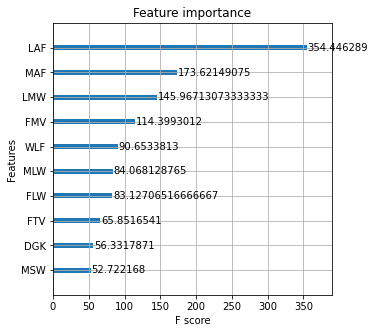

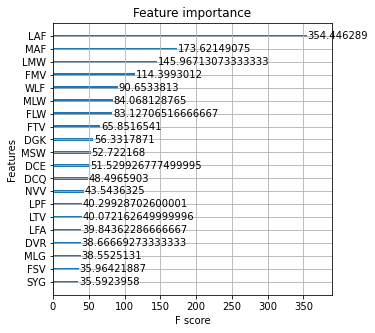

In [19]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain', show_values=True)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

xgb.plot_importance(model, max_num_features=20, importance_type='gain', show_values=True)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

========= test on hc_cancer =========
(146,)
AUC-ROC: 0.6089322574591856


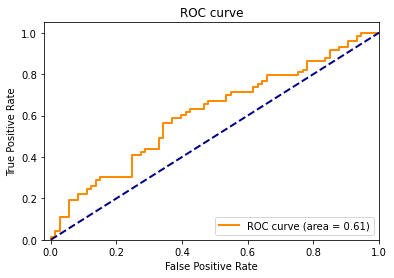

========= test on mc_cancer =========
(76,)
AUC-ROC: 0.564404432132964


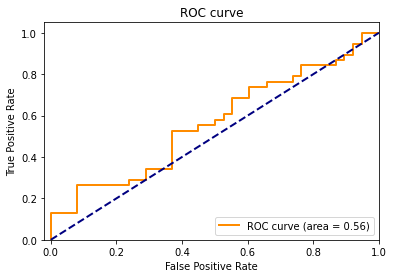

========= test on necid =========
(158,)
AUC-ROC: 0.5809966351546226


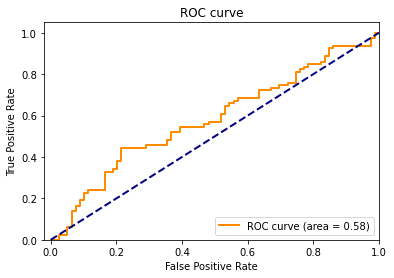

========= test on iedb =========
(2070,)
AUC-ROC: 0.5113636257555603


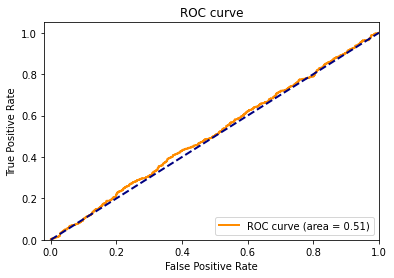

In [9]:
for ds in ['hc_cancer', 'mc_cancer', 'necid', 'iedb']:
    print("========= test on {} =========".format(ds))
    xgb_test = xgb.DMatrix(X_list[ds].values)
    y_pred = model.predict(xgb_test)
    print(y_pred.shape)
    show_roc_curve(y_test = y_list[ds], y_pred = y_pred)

    ds_list[ds]['pred'] = y_pred
    ds_list[ds].to_csv(f'{ds}.pred.csv', index=False)

========= calculate AUC =========
AUC-ROC: 0.6848280423280423


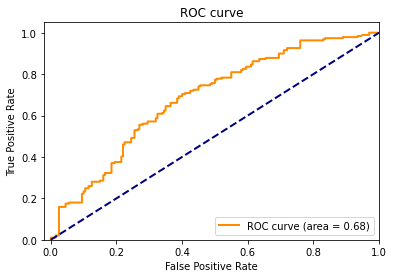

In [10]:
print("========= calculate AUC =========")
xgb_test = xgb.DMatrix(X_list['auc'].values)
y_pred = model.predict(xgb_test)
show_roc_curve(y_test = y_list['auc'], y_pred = y_pred)